##### The network architecture was taken from the article https://arxiv.org/abs/1507.05717

In [ ]:
!pip install torchmetrics

In [2]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import zipfile
import cv2
import os
from sklearn.model_selection import train_test_split
import re
from torch.nn.utils.rnn import pad_sequence
from tqdm.notebook import trange, tqdm
from torch.optim import AdamW
from torch.nn import CTCLoss
from sklearn.metrics import accuracy_score
from torchmetrics import CharErrorRate
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Extract data

In [4]:
zip_file = '/content/drive/MyDrive/CCPD2019-dl1.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

# Separation of validation and train parts

In [5]:
data_path = '/content/CCPD2019-dl1/train'
test_data_path = '/content/CCPD2019-dl1/test'
images = os.listdir(data_path)
train_images, val_images = train_test_split(images, test_size=0.2)

train_images = [os.path.join(data_path, image) 
                for image in train_images]
val_images = [os.path.join(data_path, image) 
                for image in val_images]
test_images = [os.path.join(test_data_path, image) 
                for image in os.listdir(test_data_path)]

# Define tokenizer

In [6]:
OOV_TOKEN = ''
CTC_BLANK = ''

class Tokenizer:
    def __init__(self, alphabet):
        self.id_to_symbol = dict(enumerate(alphabet, start = 1))
        self.id_to_symbol[0] = CTC_BLANK
        self.symbols_dict = {val: key for key, val in self.id_to_symbol.items()}
    
    def encode(self, words_list):
      """Encode every word from words list into a list of symbolic identifiers"""
      enc_words_list = []
      for word in words_list:
          enc_words_list.append([self.symbols_dict[s] if s in self.symbols_dict 
                                 else self.symbols_dict[CTC_BLANK]
                                 for s in word])
      return enc_words_list
          
    def decode(self, encoded_words_list):
        """Decode every encoded word from list into string form"""
        words_list = []
        for encoded_word in encoded_words_list:
            decoded_word = ''
            for i in range(len(encoded_word)):
                 if encoded_word[i] != encoded_word[i-1] or i == 0:
                    decoded_word += self.id_to_symbol[encoded_word[i]]
            words_list.append(decoded_word)
        return words_list


# Create Dataset

In [7]:
class CCPDataset(Dataset):
      def __init__(self, data, tokenizer, transform = None):
          super().__init__()
          self.images_paths = data
          self.texts = [re.split('/|-|\.', image)[-2]
                         for image in self.images_paths]
          self.labels = torch.LongTensor(tokenizer.encode(self.texts))
          self.transform = transform
          
      def __len__(self):
          return len(self.images_paths)

      def get_image_as_array(self, idx):
          return cv2.imread(self.images_paths[idx])

      def __getitem__(self, idx):
          """Return resized and scaled (Min-Max Scaling) image in grayscale"""
          width = 512
          height = 64
          image = cv2.imread(self.images_paths[idx], cv2.IMREAD_GRAYSCALE)
          image = cv2.resize(image, (height, width))
          image = torch.unsqueeze(torch.from_numpy(image).to(torch.float), 0)
          image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
          if self.transform is not None:
              image = self.transform(image)
          label = self.labels[idx]
          text = self.texts[idx]
          return image, label, text

# Initialize tokenizer, datasets and dataloaders

In [8]:
def collate_fn(batch):
    images, labels, texts = zip(*batch)
    images = torch.stack(images, 0)
    texts_lengths = torch.LongTensor([len(label) for label in labels])
    labels = pad_sequence(labels, batch_first=True, padding_value=0)
    return images, labels, texts, texts_lengths

In [9]:
def get_alphabet(data_path):
    labels = [re.split('/|-|\.', image)[-2]
             for image in os.listdir(os.path.join(data_path, 'train'))]
    labels.extend([re.split('/|-|\.', image)[-2]
             for image in os.listdir(os.path.join(data_path, 'test'))])
    return set(''.join(labels))

In [10]:
data_path = '/content/CCPD2019-dl1/'
alphabet = sorted(get_alphabet(data_path))
tokenizer = Tokenizer(alphabet)

In [11]:
train_dataset = CCPDataset(train_images, tokenizer)
val_dataset = CCPDataset(val_images, tokenizer)
test_dataset = CCPDataset(test_images, tokenizer)

In [12]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn
)

# CRNN definition

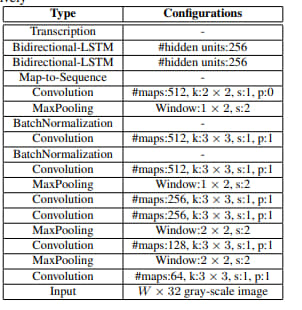

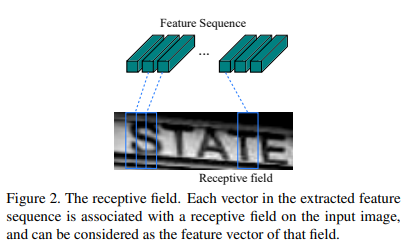

In [13]:
class CRNN(nn.Module):
    def __init__(self, alphabet_len, lstm_input_size=256, 
                 lstm_hidden_size=256, lstm_num_layers=2):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 64, (3,3), padding=1),
            nn.MaxPool2d((2,2), 2),
            nn.Conv2d(64, 128, (3,3), padding=1),
            nn.MaxPool2d((2,2),2),
            nn.Conv2d(128, 256, (3,3),padding=1),
            nn.Conv2d(256, 256, (3,3),padding=1),
            nn.MaxPool2d((1,2),2),
            nn.Conv2d(256, 512, (3,3),padding=1),
            nn.BatchNorm2d(512), 
            nn.Conv2d(512, 512, (3,3),padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d((1,2),2),
            nn.Conv2d(512, 512, (2,2))
        )
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d(
            (lstm_input_size, lstm_input_size))
        self.BiLSTM = nn.LSTM(input_size=lstm_input_size,
                              hidden_size=lstm_hidden_size,
                              num_layers=lstm_num_layers, 
                              batch_first=True, bidirectional=True)
        self.transcription = nn.Linear(lstm_hidden_size * lstm_num_layers, 
                                       alphabet_len)        
    
    def forward(self, x):
        x = self.feature_extractor(x)
        # input for LSTM: (N,L,H_{in}​), N - batch_size, L - sequence_length, H_{in} - input_size
        b, c, h, w = x.shape
        x = torch.reshape(x, (b, c * h, w)) # map to sequence
        x = self.adaptive_avg_pool(x)
        x, _ = self.BiLSTM(x)
        x = self.transcription(x)
        x = nn.functional.log_softmax(x, dim=2) 
        # (N, L, C), N - batch_size, 
        # L - sequence_length (rectangles count), 
        # C - number of classes
        return x

# Train loop

Format of predictions for CTCLoss function:
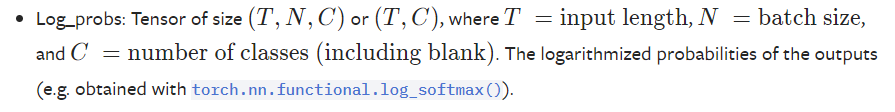

In [ ]:
!pip install neptune-client

In [ ]:
import neptune.new as neptune
run = neptune.init(
    api_token= os.getenv('NEPTUNE_API_TOKEN'),
    project = 'misha/ocr-recognition-carplates'
)

In [14]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    batches_count = 0
    for batch in tqdm(train_loader):
        model.zero_grad()
        images, targets, _, target_lengths = batch
        images=images.to(DEVICE)
        targets=targets.to(DEVICE)
        target_lengths=target_lengths.to(DEVICE)
        predictions = model(images).permute(1, 0, 2)
        input_lengths = torch.full(
            (predictions.shape[1],),
            predictions.shape[0]
        )
        loss = criterion(predictions, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        run["train/loss"].log(loss.item())
        total_loss += loss.item()
        batches_count += 1
    return total_loss/batches_count

def eval_epoch(model, val_loader, criterion, tokenizer):
    model.eval()
    total_loss = 0
    batches_count = 0
    total_epoch_accuracy = 0
    total_epoch_cer = 0
    for batch in tqdm(val_loader):
        images, targets, texts, target_lengths = batch
        images=images.to(DEVICE)
        targets=targets.to(DEVICE)
        target_lengths=target_lengths.to(DEVICE)
        predictions = model(images)
        input_lengths = torch.full(
            (predictions.shape[0],),
            predictions.shape[1]
        )
        loss = criterion(torch.permute(predictions, (1, 0, 2)), 
                         targets, input_lengths, target_lengths)
        predicted_words = torch.argmax(predictions.detach().cpu(), dim=2).numpy()
        decoded_words = tokenizer.decode(predicted_words)
        accuracy = accuracy_score(texts, decoded_words)
        cer_score = CharErrorRate()
        cer = cer_score(texts, decoded_words)
        total_loss += loss.item()
        total_epoch_accuracy += accuracy
        total_epoch_cer += cer
        batches_count += 1
        run["evaluation/loss"].log(loss.item())
        run["evaluation/accuracy"].log(accuracy)
        run["evaluation/charecter_error_rate"].log(cer)
    return total_loss/batches_count, total_epoch_accuracy/batches_count, \
           total_epoch_cer/batches_count

def train(model, train_loader, val_loader, tokenizer, num_epochs):
  model.to(DEVICE)
  criterion = torch.nn.CTCLoss(blank=0)
  optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
  run['model/parameters/n_epochs'] = num_epochs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
              optimizer=optimizer, mode='min', factor=0.5, patience=2)
  for epoch in trange(num_epochs):
      train_loss = train_epoch(model, 
                               train_loader, 
                               criterion, 
                               optimizer
                               )
      val_loss, mean_epoch_accuracy, mean_epoch_cer = eval_epoch(
                                                                model, 
                                                                val_loader, 
                                                                criterion, 
                                                                tokenizer
                                                                )
      scheduler.step(val_loss)
      run['train/epoch/loss'].log(train_loss)
      run['evaluation/epoch/loss'].log(val_loss)
      run['evaluation/epoch/accuracy'].log(mean_epoch_accuracy)
      run['evaluation/epoch/charecter_error_rate'].log(mean_epoch_cer)
      save_dir = '/content/drive/MyDrive/crnn_weights/'
      model_save_path = os.path.join(save_dir, 
                                     f'model-{epoch}-{mean_epoch_cer:.4f}.ckpt')
      torch.save(model.state_dict(), model_save_path)

In [ ]:
model = CRNN(len(alphabet))
num_epochs = 15
train(model, train_loader, val_loader, tokenizer, num_epochs)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

#### The model was trained for 15 epochs in total. Below are the graphs of the loss function and metrics.

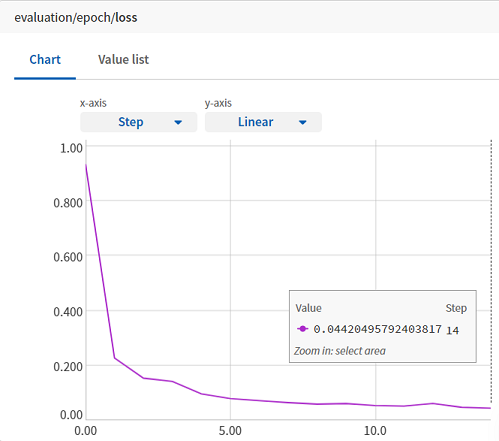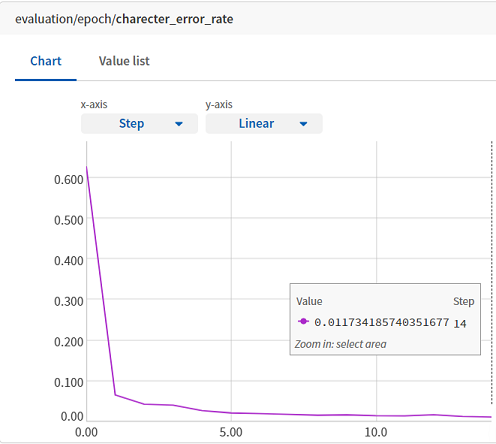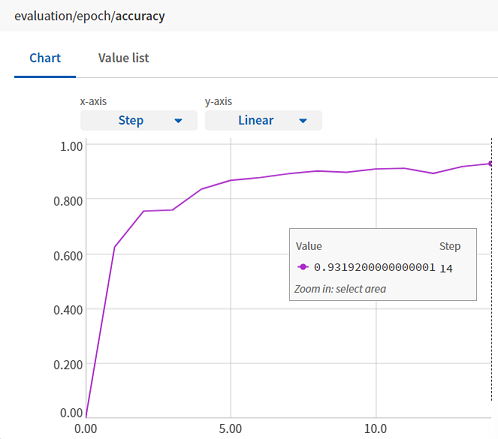

# Load model and make predictons on test dataset

In [16]:
path_to_model = '/content/model-14-0.0117.ckpt'
model = CRNN(len(alphabet))
model.load_state_dict(torch.load(path_to_model))

<All keys matched successfully>

In [15]:
def test_model(model, test_loader):
    model.eval()
    model.to(DEVICE)
    texts = []
    predictions = torch.FloatTensor([])
    for batch in tqdm(test_loader):
        batch_images, _, batch_texts, _ = batch
        batch_images=batch_images.to(DEVICE)
        predictions=torch.cat((predictions, model(batch_images).detach().cpu()))
        texts.extend(list(batch_texts))
    predicted_words = torch.argmax(predictions.detach().cpu(), dim=2).numpy()
    decoded_words = tokenizer.decode(predicted_words)
    accuracy = accuracy_score(texts, decoded_words)
    cer_score = CharErrorRate()
    cer = cer_score(texts, decoded_words)
    return accuracy, cer, texts, decoded_words
    


In [17]:
accuracy, cer, texts, decoded_words = test_model(model, test_loader)
print(f"Accuracy on test dataset: {accuracy}")
print(f"Character Error Rate on test dataset: {cer}")

  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test dataset: 0.8588858885888588
Character Error Rate on test dataset: 0.026025692000985146


# Model error analysis

In [21]:
def get_images_with_great_error(N, model, test_dataset):
    """Get top N images with max Character Error Rate metric"""
    error_image_map = {}
    cer_score = CharErrorRate()
    # get and put into dictionary Character Error Rate score for every item in test_dataset
    for i in trange(len(test_dataset)):
        image, label, text = test_dataset[i]
        image=image.unsqueeze(0).to(DEVICE)
        prediction = model(image)
        predicted_word = torch.argmax(prediction.detach().cpu(), dim=2).numpy()
        decoded_word = tokenizer.decode(predicted_word)
        error_image_map[i] = (cer_score(text, decoded_word), 
                              f"{text} CER: {cer_score(text, decoded_word):.4f} pred: {decoded_word}")
    sorted_error_image_map = sorted(error_image_map.items(), key=lambda x: x[1])[:-N:-1]
    plt.figure(figsize=(18, 4*(N//3+1)))
    for i, item in enumerate(sorted_error_image_map):
        key, value = item
        cer_score, title = value
        plt.subplot(N//3+1, 3, i+1, title=title)
        plt.axis("off")
        plt.imshow(test_dataset.get_image_as_array(key))
    plt.show();
    return sorted_error_image_map
    

  0%|          | 0/9999 [00:00<?, ?it/s]

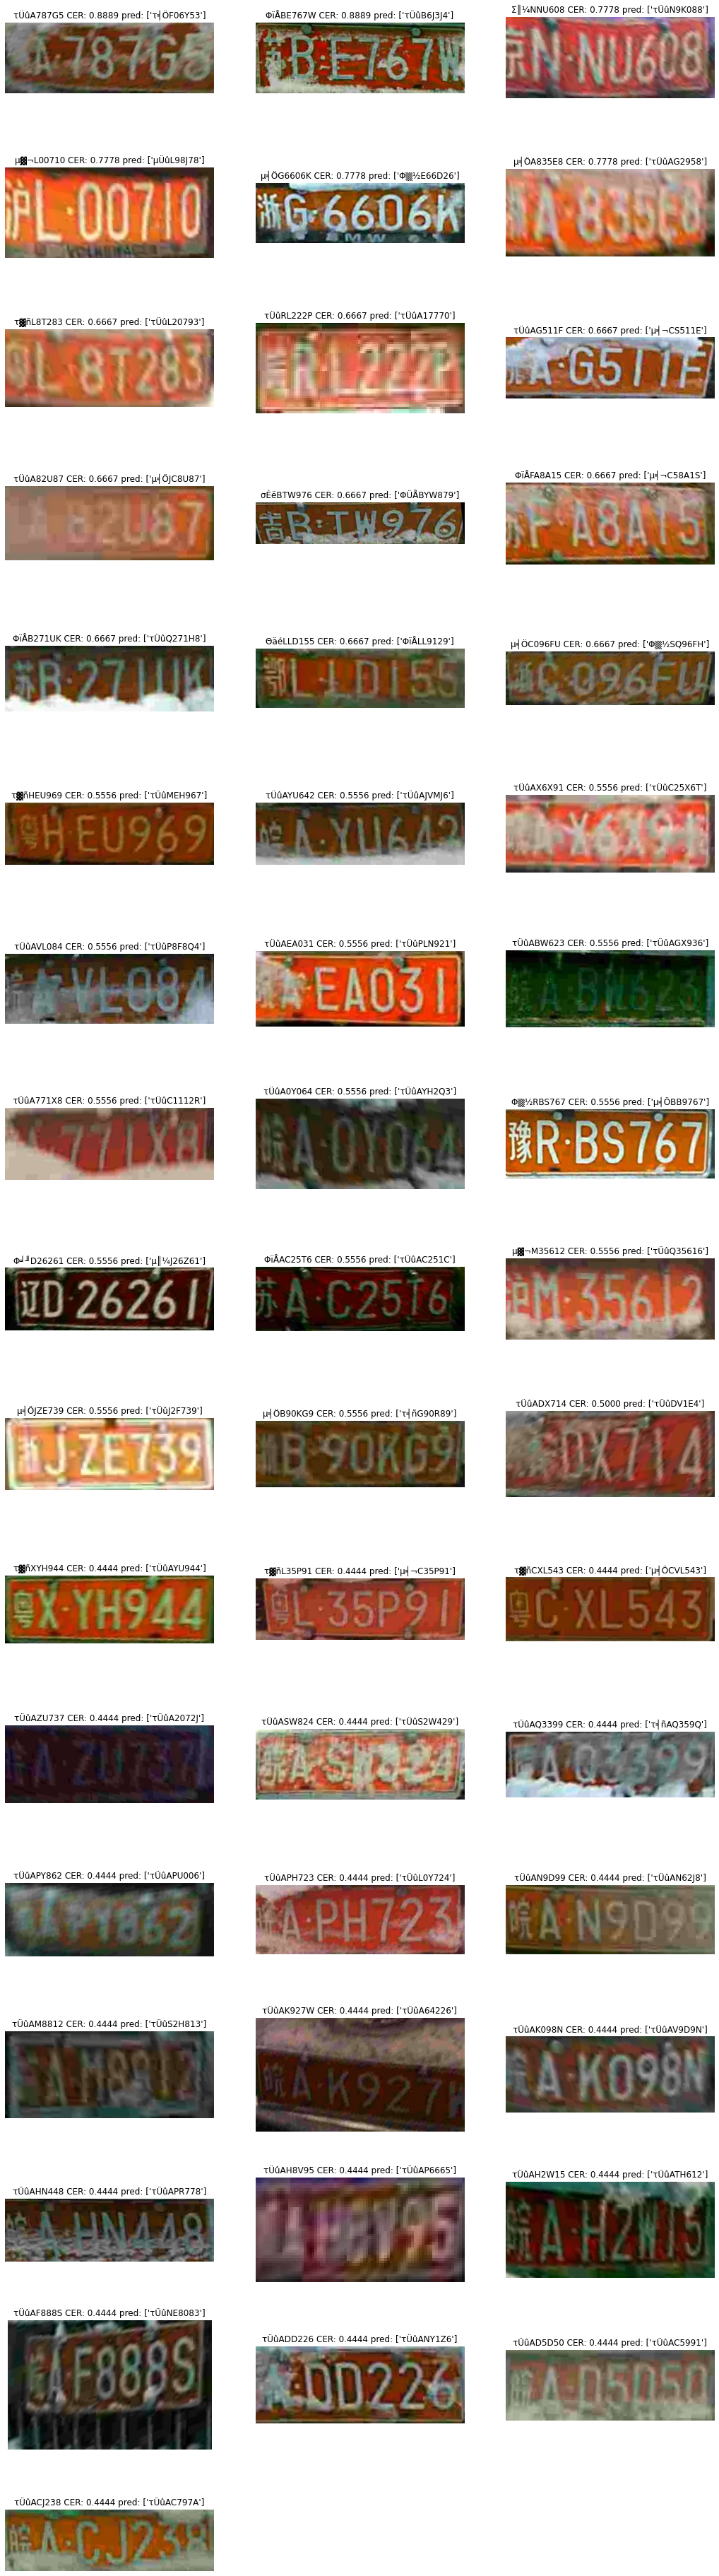

In [22]:
sorted_error_image_map = get_images_with_great_error(50, model, test_dataset)

In [ ]:
sorted_error_image_map

In [23]:
chinese_characters = {}
for text in tqdm(train_dataset.texts):
    if text[:3] not in chinese_characters:
        chinese_characters[text[:3]] = 1
    else:
        chinese_characters[text[:3]] +=1

  0%|          | 0/159984 [00:00<?, ?it/s]

In [24]:
chinese_characters

{'τÜû': 153505,
 'Φ▒½': 327,
 'ΦïÅ': 2638,
 'µ╣ÿ': 71,
 'Θù╜': 169,
 'µ╡Ö': 1064,
 'Σ║¼': 230,
 'µ▓¬': 540,
 'σåÇ': 144,
 'Θ▓ü': 202,
 'Θ¥Æ': 11,
 'τ▓ñ': 287,
 'Φ╛╜': 47,
 'σ╖¥': 95,
 'Φ╡ú': 118,
 'µ╕¥': 61,
 'Θäé': 224,
 'µÖï': 53,
 'µ┤Ñ': 48,
 'Θ╗æ': 14,
 'ΘÖò': 41,
 'µíé': 9,
 'τöÿ': 16,
 'Σ║æ': 12,
 'σÉë': 10,
 'µû░': 11,
 'Φ┤╡': 12,
 'ΦÆÖ': 15,
 'σ«ü': 4,
 'τÉ╝': 5,
 'ΦùÅ': 1}

# Выводы  
После просмотра изображений с худшими значениями метрики CER становится ясно, что большинство ошибок модели вызваны следующими причинами:  
* плохая видимость номерного знака, размытие, недостаток света на фотографии, низкое разрешение фотографии
* ошибки в парах похожих символов, например ('S', '5'), ('9', 'S'), ('2', 'Z')
* ошибки в китайских символах, которые крайне редко встречались в тренировочной выборке ('τ▓ñ', 'Φ▒½', 'Θ▓ü')  
# Варинты решения:  
* Искусственное увеличение количества обучающих примеров с редкими китайскими символами или буквами и цифрами, которые модель путает
* Попробовать использовать обработку изображений перед подачей в модель, увеличение контрастности, например, или попробовать применять фильтры для увеличения резкости  

Скорее всего большой прирост в качестве распознавания можно было бы получить от использования другой архитектуры модели.  
Стоит отметить, что на некоторых изображениях видимость номера настолько плохая, что нельзя ожидать адекватного распознавания такого номера.